## Predicting NBA MVPs Using Season Stats and Linear Regression

In [2]:
import pandas as pd
from helper_functions import *

### Find Colinear Features

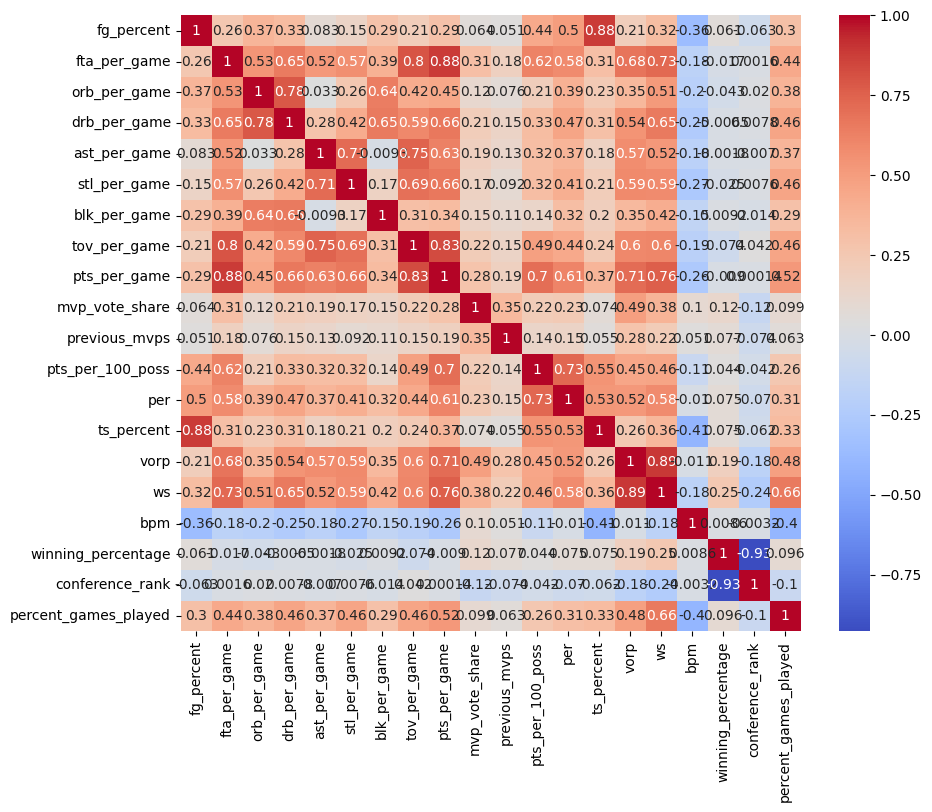

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

train_test_data = pd.read_csv("train_test_data.csv")
corr_matrix = train_test_data.drop(["seas_id", "season", "player_id", "player", "tm", "mvp_race_rank"], axis=1).corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

/tmp/ipykernel_1307/2766780383.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top10_corr['Feature Pair'] = top10_corr['Feature 1'] + ' / ' + top10_corr['Feature 2']


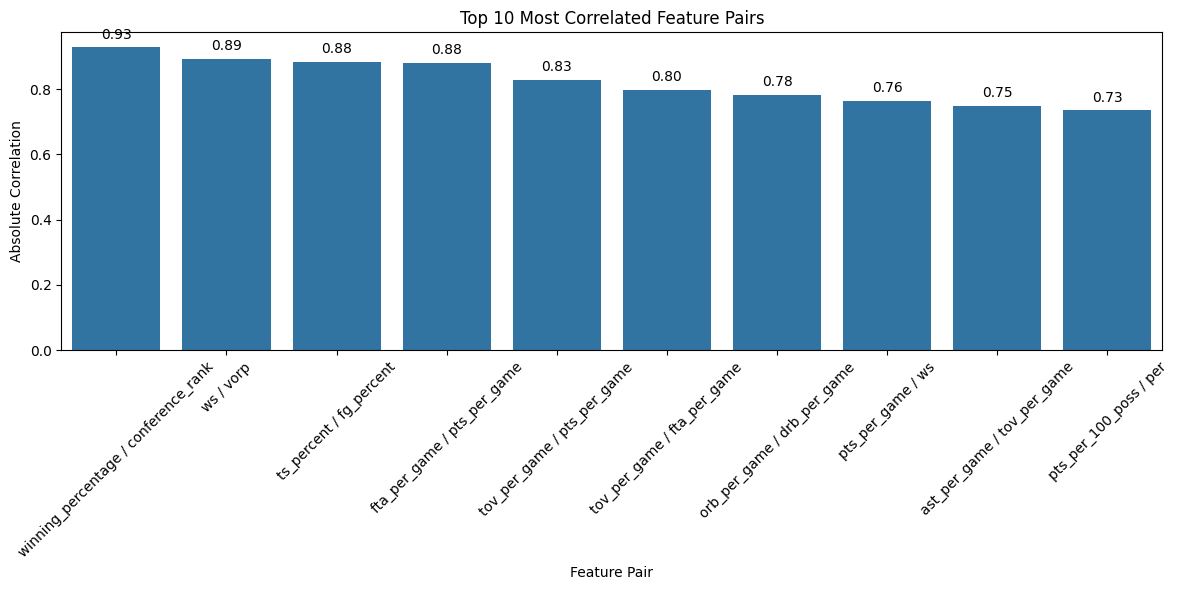

In [99]:
corr_long = corr_matrix.stack().reset_index()
corr_long.columns = ['Feature 1', 'Feature 2', 'Correlation']

corr_long = corr_long[corr_long['Feature 1'] != corr_long['Feature 2']]

corr_long['AbsCorrelation'] = corr_long['Correlation'].abs()

corr_long = corr_long.sort_values(by='AbsCorrelation', ascending=False).drop_duplicates(subset=['AbsCorrelation'])

top10_corr = corr_long.head(10)

# Add a new column for the feature pair names in the desired format
top10_corr['Feature Pair'] = top10_corr['Feature 1'] + ' / ' + top10_corr['Feature 2']

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=top10_corr, x='Feature Pair', y='AbsCorrelation', dodge=False)
plt.xticks(rotation=45)
plt.title('Top 10 Most Correlated Feature Pairs')
plt.xlabel('Feature Pair')
plt.ylabel('Absolute Correlation')

# Annotate each bar with the value of the absolute correlation
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),  # Format the number to two decimal places
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position for the text
                ha = 'center', va = 'center',  # Center alignment
                xytext = (0, 9),  # Position offset
                textcoords = 'offset points')

plt.tight_layout()
plt.show()


Many of the highly correalted stats are expected such as winning percentage and conference rank. For better results we will choose just one of the two in our feature sets.

Turnovers per game are highly correlated with most offensive box stats since they come as a byproduct of a high usage rate. Because of this I will not include turnovers in my feature sets as they might be become positively correlated with winning MVP even though they are a negative stat.

## Experiment 1: Use entire League as Data Set

### Train Test Split

In [100]:
features = ['fta_per_game', 'orb_per_game', 'drb_per_game', 'ast_per_game',
       'stl_per_game', 'blk_per_game', 'pts_per_game', 'pts_per_100_poss',
       'per', 'ts_percent', 'vorp', 'ws', 'bpm', 'conference_rank',
       'percent_games_played']
pipeline, OLS, X_test, y_test, ids_test, X_train = get_linear_regression(train_test_data, 2010, features, "mvp_vote_share")

### Predictions and Post Proccessing

In [101]:
# Predict
y_pred=pipeline.predict(X_test)
# Post process the predictions (Set very small values to 0)
thresholds, r2_scores, best_threshold, best_r2 = optimize_threshold(y_test, y_pred, 10000, 0.0001)
print(f"Best threshold: {best_threshold}, Best R-squared: {best_r2}")
y_pred = np.where(y_pred < best_threshold, 0, y_pred)
# Get R squared score for predictions
print("R Squared value for predictions after post proccessing: "+ str(r2_score(y_test, y_pred)))

Best threshold: 0.10740000000000001, Best R-squared: 0.4083900665194993
R Squared value for predictions after post proccessing: 0.4083900665194993


### Plot

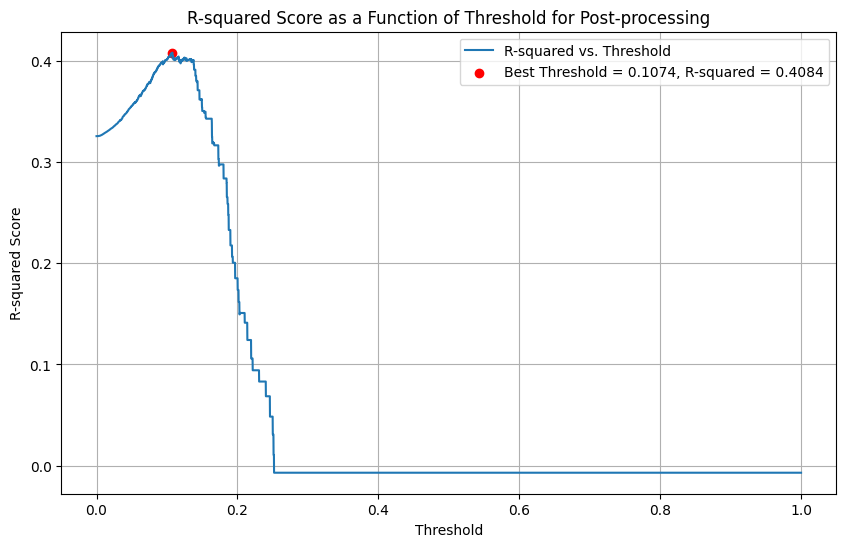

In [102]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, r2_scores, label='R-squared vs. Threshold')
plt.scatter(best_threshold, best_r2, color='red', label=f'Best Threshold = {best_threshold:.4f}, R-squared = {best_r2:.4f}')
plt.title('R-squared Score as a Function of Threshold for Post-processing')
plt.xlabel('Threshold')
plt.ylabel('R-squared Score')
plt.legend()
plt.grid(True)
plt.show()

### Identify Key Features

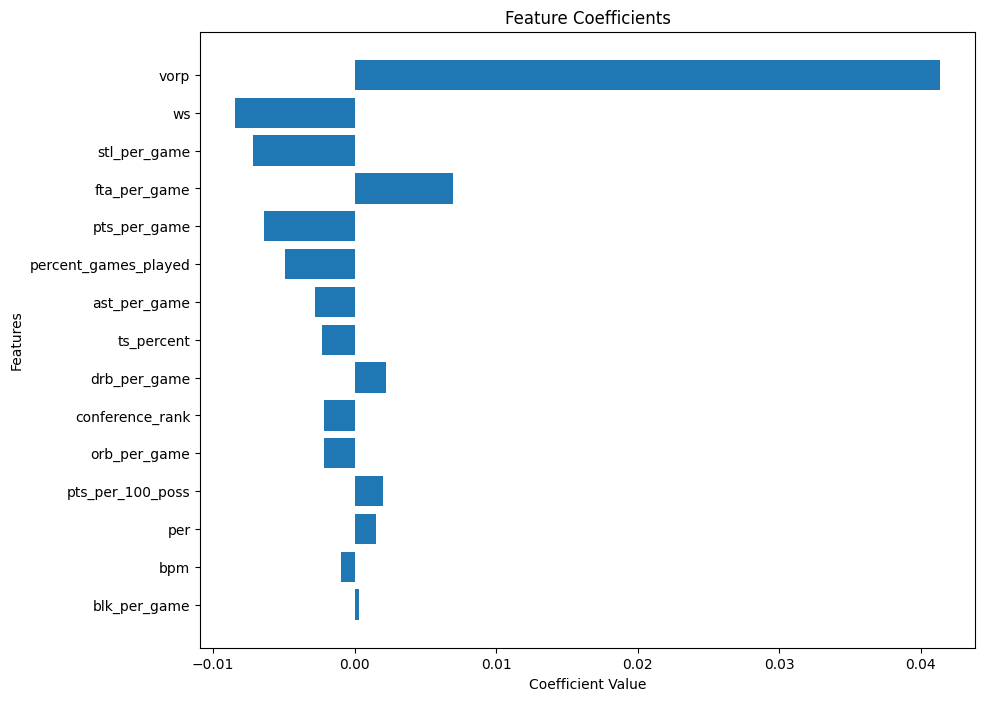

In [103]:
graph_key_features(OLS, X_train)

Value over replacement player is by far the most impactful statistic in differentiating MVPs from the league as a whole.

### Highest MVP Vote Share Seasons according to Regression

In [104]:
get_highest_estimated_mvp_vote_share_seasons(X_test, y_pred, ids_test)

Top 10 Predictions and Corresponding Features:
                     player  Predicted  season
1126           Nikola Jokić   0.251819    2022
5675           Kevin Durant   0.251147    2014
4180      Russell Westbrook   0.250073    2017
6242           LeBron James   0.246049    2013
2775           James Harden   0.240270    2019
6210           Kevin Durant   0.230670    2013
449            Nikola Jokić   0.221591    2023
4740          Stephen Curry   0.219396    2016
1762           Nikola Jokić   0.213935    2021
841   Giannis Antetokounmpo   0.210248    2022


### MVPs Since 2010 According to Regression

In [105]:
get_mvp_for_test_seasons(X_test, y_pred, ids_test)

                     player  Predicted  season
7274           LeBron James   0.193387    2011
6758           LeBron James   0.184895    2012
6242           LeBron James   0.246049    2013
5675           Kevin Durant   0.251147    2014
5040           James Harden   0.200201    2015
4740          Stephen Curry   0.219396    2016
4180      Russell Westbrook   0.250073    2017
3497           LeBron James   0.201520    2018
2775           James Harden   0.240270    2019
2127  Giannis Antetokounmpo   0.187523    2020
1762           Nikola Jokić   0.213935    2021
1126           Nikola Jokić   0.251819    2022
449            Nikola Jokić   0.221591    2023


The training results of this model are somewhat accurate, getting the right MVP 8/13 times.

### Generating 2024 MVP

In [106]:
data_for_prediction = pd.read_csv("data_for_prediction.csv")

data_for_prediction = data_for_prediction[data_for_prediction['percent_games_played'] > 0.65]

x_predict = data_for_prediction[features]
ids = data_for_prediction['player']

y_pred = pipeline.predict(x_predict)

# Create a DataFrame for predictions
mvp_2024_predictions = pd.DataFrame({'player': ids, 'Predicted': y_pred})

# Sort by 'Predicted' in descending order and take the top 5
top_5_mvp_predictions = mvp_2024_predictions.sort_values(by='Predicted', ascending=False).head(5)

print("Predicted MVP vote share for 2024 (Top 5):\n", top_5_mvp_predictions)

Predicted MVP vote share for 2024 (Top 5):
                       player  Predicted
448             Nikola Jokić   0.198406
195    Giannis Antetokounmpo   0.141202
385              Luka Dončić   0.140701
524  Shai Gilgeous-Alexander   0.135728
156         Domantas Sabonis   0.089842


This model projects Niola Jokic as the 2024 MVP.

## Experiment 2: Only Use Recipients of MVP Votes as Data Set

### Train Test Split

In [3]:
# Filter out Players with no MVP Votes
train_test_data = pd.read_csv("train_test_data.csv")
complete_mvp_data = train_test_data[train_test_data['mvp_vote_share'] != 0]
print("Amount of players in full dataset: " + str(train_test_data.shape[0]))
print("Amount of players in MVP dataset: " + str(complete_mvp_data.shape[0]))

features = ['fg_percent', 'fta_per_game', 'orb_per_game', 'drb_per_game',
       'ast_per_game', 'stl_per_game', 'blk_per_game', 'tov_per_game',
       'pts_per_game', 'previous_mvps', 'pts_per_100_poss', 'per', 'vorp',
       'ws', 'bpm', 'winning_percentage', 'conference_rank',
       'percent_games_played']

pipeline, OLS, X_test, y_test, ids_test, X_train = get_linear_regression(complete_mvp_data, 2010, features, "mvp_vote_share")

Amount of players in full dataset: 21578
Amount of players in MVP dataset: 727


### Predict and get Metrics

R Squared value for predictions: 0.5668686172565014


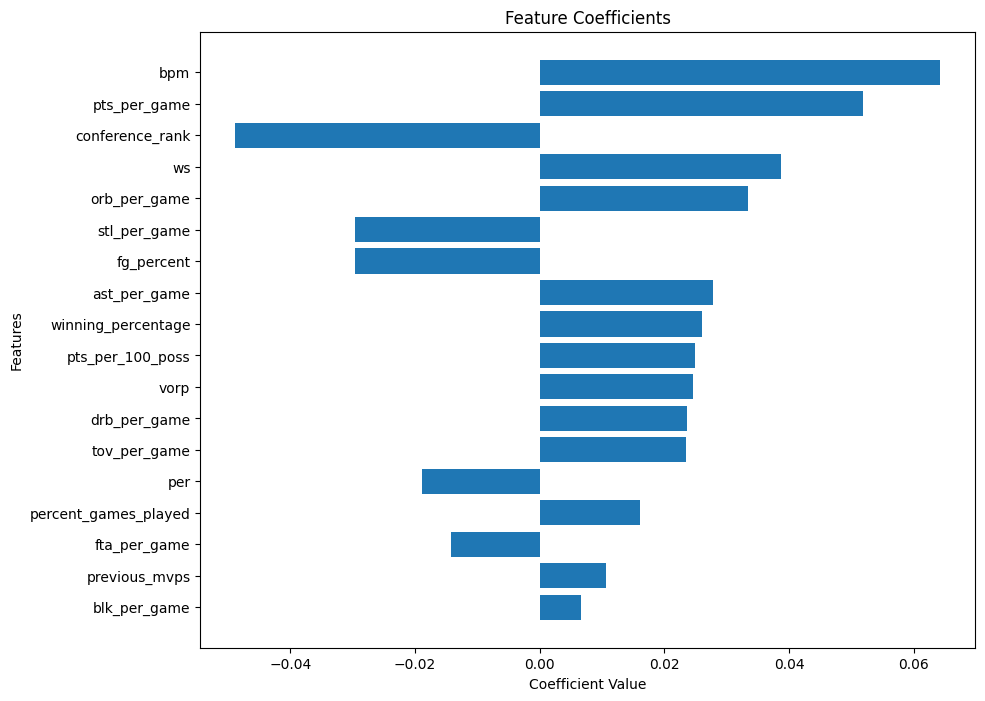

In [4]:
# Predict
y_pred=pipeline.predict(X_test)
from sklearn.metrics import r2_score

print("R Squared value for predictions: "+ str(r2_score(y_test, y_pred)))

graph_key_features(OLS, X_train)

Box Plus Minus is the most impactful statistic to differentiate MVP winners from other MVP candidates according to the regression.

### Highest MVP Vote Share Seasons according to Regression

In [5]:
get_highest_estimated_mvp_vote_share_seasons(X_test, y_pred, ids_test)

Top 10 Predictions and Corresponding Features:
                     player  Predicted  season
2775           James Harden   0.658345    2019
4180      Russell Westbrook   0.645685    2017
4740          Stephen Curry   0.639094    2016
3949           James Harden   0.601855    2017
6242           LeBron James   0.594644    2013
5675           Kevin Durant   0.592152    2014
3384           James Harden   0.578084    2018
2127  Giannis Antetokounmpo   0.570332    2020
449            Nikola Jokić   0.553774    2023
1762           Nikola Jokić   0.544356    2021


### MVPs Since 2010 According to Regression

In [6]:
get_mvp_for_test_seasons(X_test, y_pred, ids_test)

                     player  Predicted  season
7274           LeBron James   0.442866    2011
6758           LeBron James   0.457417    2012
6242           LeBron James   0.594644    2013
5675           Kevin Durant   0.592152    2014
5040           James Harden   0.477488    2015
4740          Stephen Curry   0.639094    2016
4180      Russell Westbrook   0.645685    2017
3384           James Harden   0.578084    2018
2775           James Harden   0.658345    2019
2127  Giannis Antetokounmpo   0.570332    2020
1762           Nikola Jokić   0.544356    2021
1126           Nikola Jokić   0.539420    2022
449            Nikola Jokić   0.553774    2023


This model has a higher accuracy, correctly predicting 9/13 MVPs.

### Predicting 2024 MVP

In [111]:
data_for_prediction = pd.read_csv("data_for_prediction.csv")

# Filter out rows where 'pts_per_game' is less than 10
filtered_data = data_for_prediction[data_for_prediction['pts_per_game'] >= 10]
filtered_data = filtered_data[filtered_data['percent_games_played'] >= 0.65]

# Proceed with the prediction using the filtered data
x_predict = filtered_data[features]
ids = filtered_data['player']

y_pred = pipeline.predict(x_predict)

# Create a DataFrame for predictions with the filtered data
mvp_2024_predictions = pd.DataFrame({'player': ids, 'Predicted': y_pred})

# Sort by 'Predicted' in descending order and take the top 5
top_5_mvp_predictions = mvp_2024_predictions.sort_values(by='Predicted', ascending=False).head(5)

print("Predicted MVP vote share for 2024 (Top 5) with pts_per_game >= 10:\n", top_5_mvp_predictions)

Predicted MVP vote share for 2024 (Top 5) with pts_per_game >= 10:
                       player  Predicted
448             Nikola Jokić   0.557052
385              Luka Dončić   0.374533
195    Giannis Antetokounmpo   0.345841
524  Shai Gilgeous-Alexander   0.340440
274             Jayson Tatum   0.292047


Again, Jokic is giving the MVP award by the model, with Luka coming is second.

### Discussion

### Futher Optimization: Feature Engineering (For Experiment 2)

I will apply a polynomial factor to the past MVPs feature in an attempt to create a regression that understands voter fatigue.

R Squared value for predictions: 0.5643260823585894


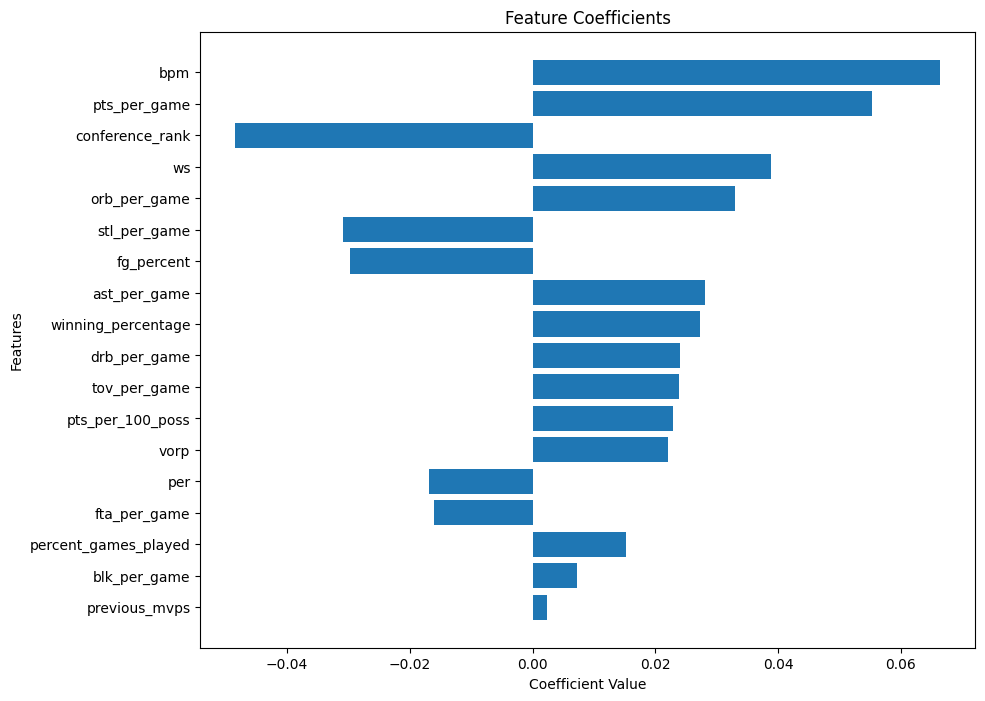

                     player  Predicted  season
7096           Derrick Rose   0.437965    2011
6758           LeBron James   0.448294    2012
6242           LeBron James   0.578749    2013
5675           Kevin Durant   0.600749    2014
5040           James Harden   0.481660    2015
4740          Stephen Curry   0.642283    2016
4180      Russell Westbrook   0.654072    2017
3384           James Harden   0.588479    2018
2775           James Harden   0.657328    2019
2127  Giannis Antetokounmpo   0.574492    2020
1762           Nikola Jokić   0.556075    2021
1126           Nikola Jokić   0.542531    2022
449            Nikola Jokić   0.547973    2023


In [112]:
from sklearn.metrics import r2_score
# Polynomial Weighing of Past MVPs
complete_mvp_data_modified = complete_mvp_data.copy()

# Apply the transformation on the copy
complete_mvp_data_modified["previous_mvps"] = complete_mvp_data_modified["previous_mvps"].apply(lambda x: x**2)

features = ['fg_percent', 'fta_per_game', 'orb_per_game', 'drb_per_game',
       'ast_per_game', 'stl_per_game', 'blk_per_game', 'tov_per_game',
       'pts_per_game', 'previous_mvps', 'pts_per_100_poss', 'per', 'vorp',
       'ws', 'bpm', 'winning_percentage', 'conference_rank',
       'percent_games_played']

pipeline, OLS, X_test, y_test, ids_test, X_train = get_linear_regression(complete_mvp_data_modified, 2010, features, "mvp_vote_share")

# Predict
y_pred=pipeline.predict(X_test)

print("R Squared value for predictions: "+ str(r2_score(y_test, y_pred)))

graph_key_features(OLS, X_train)

get_mvp_for_test_seasons(X_test, y_pred, ids_test)

Applying this polynomial factor increased the model accuracy, with it now predicting 10/13 past MVPs correctly.

### Discussion

### Further Optimization: Iterative Feature Selection (For Experiment 2)

I will be using a custom accuracy measurement other than R2 to selectively pick a feature set that correctly guesses the highest number of MVPs in the test set.

In [116]:
from itertools import combinations
from tqdm import tqdm

features = ['fg_percent', 'fta_per_game', 'orb_per_game', 'drb_per_game',
            'ast_per_game', 'stl_per_game', 'blk_per_game', 'tov_per_game',
            'pts_per_game', 'previous_mvps', 'pts_per_100_poss', 'per', 'vorp',
            'ws', 'bpm', 'winning_percentage', 'conference_rank',
            'percent_games_played']

feature_combinations = [list(combo) for r in range(1, len(features) + 1) for combo in combinations(features, r)]

max_score = 0
best_feature_sets = []

for feature_set in tqdm(feature_combinations, desc='Iterating Feature combinations'):
   pipeline, OLS, X_test, y_test, ids_test, X_train = get_linear_regression(complete_mvp_data, 2010, feature_set, "mvp_vote_share")
   y_pred = pipeline.predict(X_test)
   X_test_with_predictions = X_test.copy()
   X_test_with_predictions['Predicted'] = y_pred
   # Add identifiers to the DataFrame
   X_test_with_predictions = pd.concat([ids_test, X_test_with_predictions], axis=1)
   X_test_with_predictions['predicted_mvp_race_rank'] = X_test_with_predictions.groupby(['season'])['Predicted'].rank(method='dense', ascending=False)
   score = get_mvp_prediction_accuracy(X_test_with_predictions[['player', 'season', 'predicted_mvp_race_rank']], complete_mvp_data[['player', 'season', 'mvp_race_rank']])
    
   if score > max_score:
      max_score = score
      best_feature_sets = [feature_set]
   elif score == max_score:
      best_feature_sets.append(feature_set)

print(f"Best Feature Sets: {best_feature_sets}, Best Score: {max_score}, Best Possible Score: 10")


Iterating Feature combinations: 100%|██████████| 262143/262143 [1:01:36<00:00, 70.92it/s]  

Best Feature Sets: [['fg_percent', 'stl_per_game', 'blk_per_game', 'bpm', 'conference_rank', 'percent_games_played'], ['fg_percent', 'orb_per_game', 'ast_per_game', 'stl_per_game', 'bpm', 'winning_percentage', 'percent_games_played'], ['fg_percent', 'stl_per_game', 'blk_per_game', 'bpm', 'winning_percentage', 'conference_rank', 'percent_games_played'], ['fg_percent', 'fta_per_game', 'orb_per_game', 'drb_per_game', 'ast_per_game', 'per', 'winning_percentage', 'percent_games_played'], ['fg_percent', 'ast_per_game', 'stl_per_game', 'blk_per_game', 'pts_per_game', 'vorp', 'winning_percentage', 'percent_games_played'], ['fg_percent', 'fta_per_game', 'orb_per_game', 'drb_per_game', 'ast_per_game', 'stl_per_game', 'per', 'winning_percentage', 'percent_games_played'], ['fg_percent', 'fta_per_game', 'orb_per_game', 'drb_per_game', 'ast_per_game', 'blk_per_game', 'per', 'winning_percentage', 'percent_games_played'], ['fg_percent', 'fta_per_game', 'ast_per_game', 'stl_per_game', 'blk_per_game', '

In [117]:
print("Smallest accurate feature set: "+ str(min(best_feature_sets, key=len)))
print("Largest Accurate Feature Set: " + str(max(best_feature_sets, key=len)))

Smallest accurate feature set: ['fg_percent', 'stl_per_game', 'blk_per_game', 'bpm', 'conference_rank', 'percent_games_played']
Largest Accurate Feature Set: ['fg_percent', 'fta_per_game', 'orb_per_game', 'ast_per_game', 'stl_per_game', 'blk_per_game', 'tov_per_game', 'pts_per_game', 'per', 'winning_percentage', 'percent_games_played']


In [118]:
for feature_set in best_feature_sets:
    if "bpm" in feature_set:
        print(feature_set)

['fg_percent', 'stl_per_game', 'blk_per_game', 'bpm', 'conference_rank', 'percent_games_played']
['fg_percent', 'orb_per_game', 'ast_per_game', 'stl_per_game', 'bpm', 'winning_percentage', 'percent_games_played']
['fg_percent', 'stl_per_game', 'blk_per_game', 'bpm', 'winning_percentage', 'conference_rank', 'percent_games_played']
['fg_percent', 'fta_per_game', 'ast_per_game', 'stl_per_game', 'blk_per_game', 'pts_per_game', 'bpm', 'winning_percentage', 'percent_games_played']
['fg_percent', 'ast_per_game', 'stl_per_game', 'blk_per_game', 'pts_per_game', 'per', 'bpm', 'winning_percentage', 'percent_games_played']
['fg_percent', 'fta_per_game', 'ast_per_game', 'stl_per_game', 'blk_per_game', 'pts_per_game', 'per', 'bpm', 'winning_percentage', 'percent_games_played']


I am looking for the best feature set containing BPM since we know from previous experiments that it is a strong predictor of MVP vote success. I will use the smallest of these feature sets to predict MVP.

### Training using Accurate Feature Set

R Squared value for predictions: 0.5099601798736191


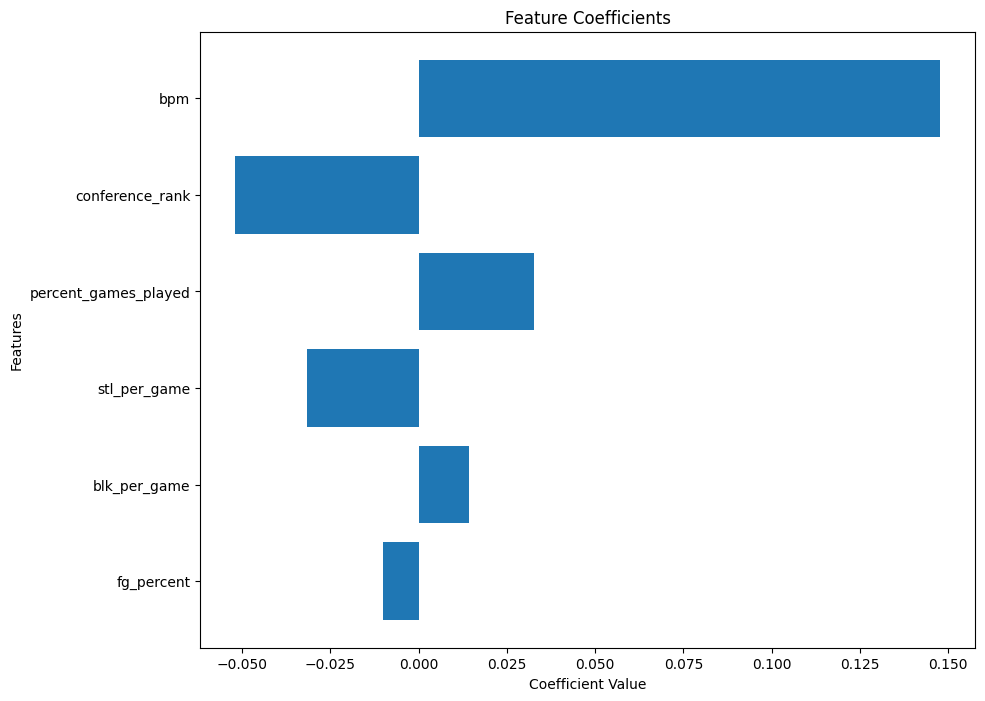

                     player  Predicted  season
7096           Derrick Rose   0.373219    2011
6758           LeBron James   0.507379    2012
6242           LeBron James   0.576113    2013
5675           Kevin Durant   0.520645    2014
5301          Stephen Curry   0.480110    2015
4740          Stephen Curry   0.582510    2016
4180      Russell Westbrook   0.502758    2017
3384           James Harden   0.471655    2018
2718  Giannis Antetokounmpo   0.510725    2019
2127  Giannis Antetokounmpo   0.583134    2020
1762           Nikola Jokić   0.598977    2021
1126           Nikola Jokić   0.578775    2022
449            Nikola Jokić   0.624680    2023


In [119]:
features = ['fg_percent', 'stl_per_game', 'blk_per_game', 'bpm', 'conference_rank', 'percent_games_played']

pipeline, OLS, X_test, y_test, ids_test, X_train = get_linear_regression(complete_mvp_data, 2010, features, "mvp_vote_share")

# Predict
y_pred=pipeline.predict(X_test)

print("R Squared value for predictions: "+ str(r2_score(y_test, y_pred)))

graph_key_features(OLS, X_train)

get_mvp_for_test_seasons(X_test, y_pred, ids_test)

The model now gets 12/13 past MVPs correct with it only missing Joel Embiid in 2023 (giving it instead to Jokic who was runner up).

### Generating 2024 MVP

In [120]:
data_for_prediction = pd.read_csv("data_for_prediction.csv")

# Filter out rows where 'pts_per_game' is less than 10
filtered_data = data_for_prediction[data_for_prediction['pts_per_game'] >= 10]
filtered_data = filtered_data[filtered_data['percent_games_played'] >= 0.65]

# Proceed with the prediction using the filtered data
x_predict = filtered_data[features]
ids = filtered_data['player']

y_pred = pipeline.predict(x_predict)

# Create a DataFrame for predictions with the filtered data
mvp_2024_predictions = pd.DataFrame({'player': ids, 'Predicted': y_pred})

# Sort by 'Predicted' in descending order and take the top 5
top_5_mvp_predictions = mvp_2024_predictions.sort_values(by='Predicted', ascending=False).head(5)

print("Predicted MVP vote share for 2024 (Top 5) with pts_per_game >= 10:\n", top_5_mvp_predictions)

Predicted MVP vote share for 2024 (Top 5) with pts_per_game >= 10:
                       player  Predicted
448             Nikola Jokić   0.702286
524  Shai Gilgeous-Alexander   0.457936
195    Giannis Antetokounmpo   0.383554
385              Luka Dončić   0.349673
274             Jayson Tatum   0.265766


Again, the model awards the MVP to Jokic.

### Conclusion

Across all approaches taking in these experiments, Nikola Jokic is the MVP winner.